1. Predict Future transaction and Churn rate by BG/NBD Model
2. Predict future Monetary by Gamma - Gamma model
3. https://github.com/sibylhe/clv/blob/master/customer_lifetime_modeling.ipynb

# Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import math

In [3]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [4]:
data = pd.read_csv('/content/drive/MyDrive/BA - Project 2/Data/online_retail_II.csv')
df = data.copy()


In [5]:
df.dropna(axis = 0, subset = ["Description"], inplace = True)

df.dropna(axis = 0, subset = ["Customer ID"], inplace = True)

df.drop(df[df.duplicated()].index, axis=0, inplace=True)

In [6]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df= df[(df['Price'] > 0)]
df= df[(df['Quantity'] > 0)]

In [7]:
wrong_stock_codes= df[df["StockCode"].astype(str).str.contains(r"^[a-zA-Z''-'\s]{1,40}$")]["StockCode"].unique().tolist()

df[df["StockCode"].isin(wrong_stock_codes)].groupby(["StockCode"]).agg({"StockCode": "count"})
df= df[~df["StockCode"].isin(wrong_stock_codes)].reset_index(drop=True)

In [8]:
# other non-numeric stock (number+alphabet)
wrong_stock_codes2= df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()
df[df["StockCode"].isin(wrong_stock_codes2)].groupby(["StockCode"]).agg({"StockCode": "count"})
df= df[~df["StockCode"].isin(wrong_stock_codes2)].reset_index(drop=True)

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["Customer ID"]= df["Customer ID"].astype('object')

In [10]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00


In [11]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
776822,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
776823,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
776824,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
776825,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


# Calculate customer metric

1. Frequency - the number of dates on which a customer made a purchase subsequent to the date of the customer's first purchase.

2. Age (T) - the number of time units, e.g. days, since the date of a customer's first purchase to the current date (or last date in the dataset).

3. Recency - the age of the customer (as previously defined) at the time of their last purchase.

4. Monetary Value - the average per transaction-date spend by a customer during repeat purchases. (Margin and other monetary values may also be used if available.)

In [12]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [ ]:
# Check time
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2009-12-01 07:45:00
2011-12-09 12:50:00


In [13]:
modeldata = summary_data_from_transaction_data(df, 'Customer ID', 'InvoiceDate',
                                               monetary_value_col='TotalPrice',
                                               observation_period_end='2011-12-9')
modeldata.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,2.0,322.0,647.0,38662.955000
12347.0,7.0,402.0,404.0,615.714286
12348.0,4.0,363.0,438.0,359.310000
12349.0,2.0,571.0,589.0,1305.085000
12350.0,0.0,0.0,310.0,0.000000


In [14]:
modeldata.describe()

,frequency,recency,T,monetary_value
count,5853.000000,5853.000000,5853.000000,5853.000000
mean,4.617974,273.761148,473.544507,315.851334
std,9.924267,258.648259,223.176716,2309.171569
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,311.000000,0.000000
50%,2.000000,223.000000,529.000000,206.868000
75%,5.000000,512.000000,666.000000,365.441111
max,248.000000,738.000000,738.000000,168469.600000


# FIT BG Model

In [15]:
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5853 subjects, a: 0.11, alpha: 63.84, b: 2.43, r: 0.67>


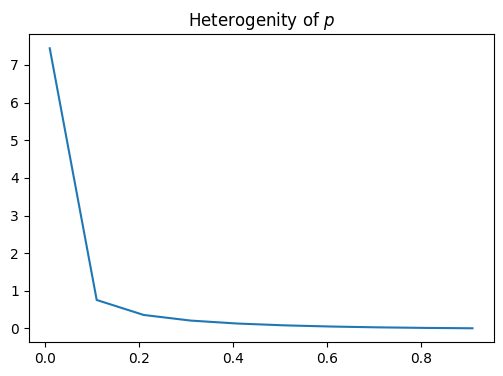

mean:  0.04320663049327833
median:  0.000556001693777651
std:  0.10800662518765625


In [16]:
from scipy.stats import gamma, beta

x = np.arange (0.01, 1, 0.1)
a, b = bgf.params_['a'], bgf.params_['b']
gbd = beta.pdf(x, a, b)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $p$')
temp = plt.plot(x, gbd)
plt.show()
print('mean: ', beta.mean(a, b))
print('median: ', beta.median(a, b))
print('std: ', beta.std(a, b))

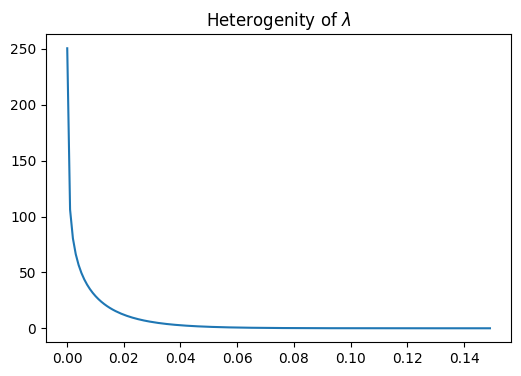

mean:  0.010476142172491721
median:  0.0059290541746306
std:  0.012810418920530637


In [17]:
x = np.arange (0.0001, 0.15, 0.001)
r, alpha = bgf.params_['r'], bgf.params_['alpha']
ggd = gamma.pdf(x, r, scale=1.0/alpha)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $\lambda$')
temp = plt.plot(x, ggd)
plt.show()
print('mean: ', gamma.mean(r, scale=1.0/alpha))
print('median: ', gamma.median(r, scale=1.0/alpha))
print('std: ', gamma.std(r, scale=1.0/alpha))

In [18]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.668769,0.016025,0.637359,0.700179
alpha,63.837331,1.956796,60.002010,67.672652
a,0.109909,0.015704,0.079130,0.140687
b,2.433880,0.533915,1.387407,3.480352


# F_R matrix & Churn active alive


**Frequency-recency matrix**

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

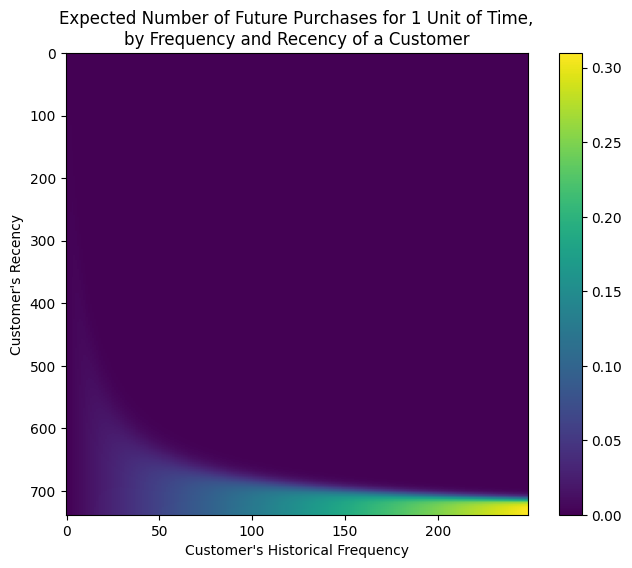

In [50]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(bgf)

Target: expected number of purchase in next 1 day
X-axis: frequency
Y-axis: recency

Up-right: dark, rare chance of purchase, people have high frequency, but rarely buy things recently, they might quit the product/your business
Diagonal: blue curve, relatively good customer
Recency is more important than frequency. People with good recency (bottom) is more likely to buy than people with high frequency but bad recency (up right).

**Churn/Active Probability**

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

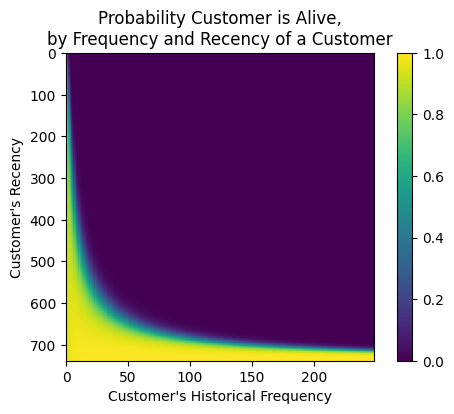

In [51]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(6,4))
plot_probability_alive_matrix(bgf)

Up-right: dead/silent
Bottom-left: high activity. Active probability decrease exponentially with recency (time between first and last purchase) decrease.

# Predict future transaction number

# **Predict in 1 day**

In [ ]:
t = 1
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])

In [ ]:
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
14606.0,176.0,735.0,736.0,167.237216,0.220695
17841.0,192.0,736.0,737.0,354.136667,0.240394
15311.0,195.0,738.0,738.0,583.837949,0.243872
12748.0,195.0,735.0,735.0,251.135333,0.244788
14911.0,248.0,737.0,738.0,1123.968387,0.309916


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 600x400 with 0 Axes>

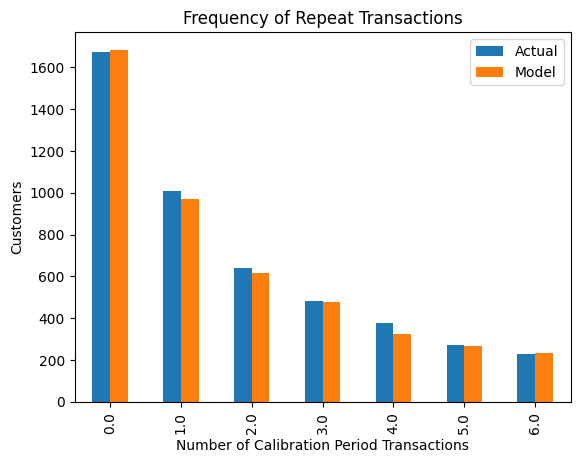

In [52]:
from lifetimes.plotting import plot_period_transactions
fig = plt.figure(figsize=(6,4))
plot_period_transactions(bgf)

In [ ]:
# set calibration_period_end='2011-08-31'
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-12-09' )

In [ ]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,2.0,322.0,547.0,0.0,100.0
12347.0,5.0,275.0,304.0,2.0,100.0
12348.0,3.0,190.0,338.0,1.0,100.0
12349.0,1.0,182.0,489.0,1.0,100.0
12350.0,0.0,0.0,210.0,0.0,100.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

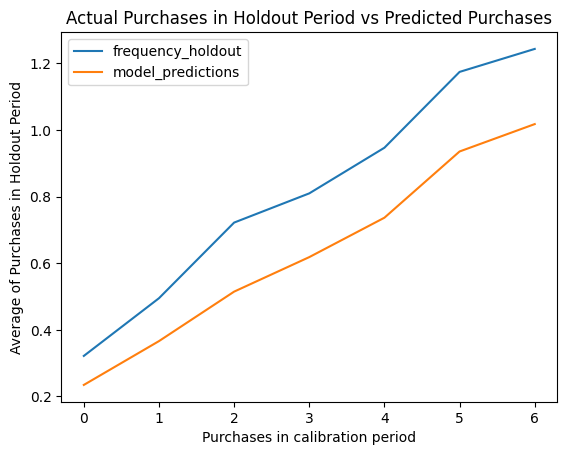

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

In [ ]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

In [ ]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
Customer ID,,,,,,
12346.0,2.0,322.0,547.0,0.0,100.0,0.371117
12347.0,5.0,275.0,304.0,2.0,100.0,1.445897
12348.0,3.0,190.0,338.0,1.0,100.0,0.746808
12349.0,1.0,182.0,489.0,1.0,100.0,0.238714
12350.0,0.0,0.0,210.0,0.0,100.0,0.231300
...,...,...,...,...,...,...
18283.0,12.0,510.0,558.0,6.0,100.0,1.938653
18284.0,0.0,0.0,331.0,0.0,100.0,0.161190
18285.0,0.0,0.0,560.0,0.0,100.0,0.102444


In [ ]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  1.26671435829847
SMAPE 1.4377325076147813
R2:  0.6198551533031857


 **gamma-gamma**

In [ ]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

In [ ]:
len(returning_customers_summary)/len(modeldata)

0.7139928241927217

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4179 subjects, p: 2.23, q: 3.49, v: 444.13>


In [ ]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10)

Customer ID
12346.0    24944.247004
12347.0      585.645746
12348.0      367.615990
12349.0      979.646854
12350.0      397.339834
12351.0      397.339834
12352.0      222.633587
12353.0      251.742300
12354.0      397.339834
12355.0      426.644537
dtype: float64

# **Predict in 1 month with duration = 100 days**

In [19]:
tm = 30
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(tm, modeldata['frequency'], modeldata['recency'], modeldata['T'])

In [20]:
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
14606.0,176.0,735.0,736.0,167.237216,6.607913
17841.0,192.0,736.0,737.0,354.136667,7.197730
15311.0,195.0,738.0,738.0,583.837949,7.301897
12748.0,195.0,735.0,735.0,251.135333,7.329264
14911.0,248.0,737.0,738.0,1123.968387,9.279331


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

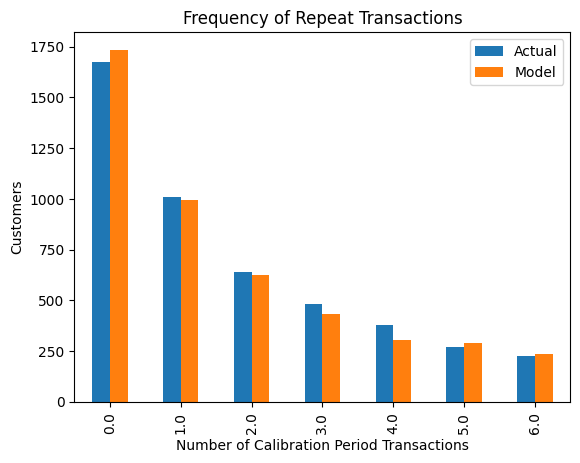

In [22]:
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_period_transactions(bgf)

In [23]:
# set calibration_period_end='2011-08-31'
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-12-09' )

In [24]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,2.0,322.0,547.0,0.0,100.0
12347.0,5.0,275.0,304.0,2.0,100.0
12348.0,3.0,190.0,338.0,1.0,100.0
12349.0,1.0,182.0,489.0,1.0,100.0
12350.0,0.0,0.0,210.0,0.0,100.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

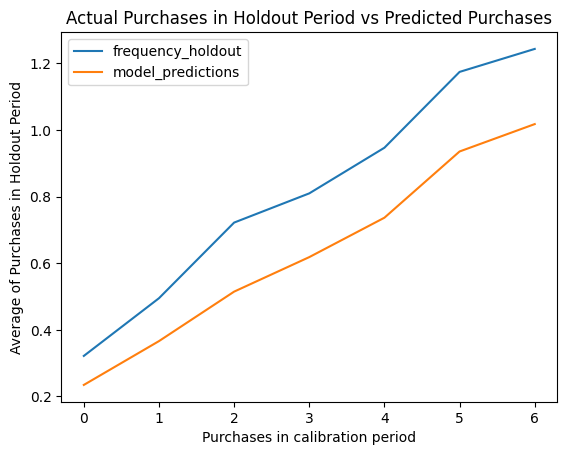

In [25]:
bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

In [26]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
Customer ID,,,,,,
12346.0,2.0,322.0,547.0,0.0,100.0,0.371117
12347.0,5.0,275.0,304.0,2.0,100.0,1.445897
12348.0,3.0,190.0,338.0,1.0,100.0,0.746808
12349.0,1.0,182.0,489.0,1.0,100.0,0.238714
12350.0,0.0,0.0,210.0,0.0,100.0,0.231300
...,...,...,...,...,...,...
18283.0,12.0,510.0,558.0,6.0,100.0,1.938653
18284.0,0.0,0.0,331.0,0.0,100.0,0.161190
18285.0,0.0,0.0,560.0,0.0,100.0,0.102444


In [27]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  1.26671435829847
SMAPE 1.4377325076147813
R2:  0.6198551533031857


**gamma- gamma**

In [29]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

In [30]:
len(returning_customers_summary)/len(modeldata)

0.7139928241927217

In [31]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4179 subjects, p: 2.23, q: 3.49, v: 444.13>

In [33]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.226234,0.112592,2.005554,2.446913
q,3.488383,0.110264,3.272265,3.704500
v,444.128389,34.419099,376.666955,511.589822


In [34]:
returning_customers_summary["expected_avg_sales_p"] = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'], \
    returning_customers_summary['monetary_value'])

In [36]:
returning_customers_summary.head(10)

,frequency,recency,T,monetary_value,predicted_purchases,expected_avg_sales_p
Customer ID,,,,,,
12346.0,2.0,322.0,647.0,38662.955000,0.096628,24944.247004
12347.0,7.0,402.0,404.0,615.714286,0.483704,585.645746
12348.0,4.0,363.0,438.0,359.310000,0.266830,367.615990
12349.0,2.0,571.0,589.0,1305.085000,0.118312,979.646854
12352.0,8.0,356.0,392.0,198.223750,0.555462,222.633587
12353.0,1.0,204.0,408.0,89.000000,0.094813,251.742300
12355.0,1.0,353.0,567.0,459.400000,0.072655,426.644537
12356.0,5.0,402.0,424.0,962.658000,0.340040,859.370605
12357.0,1.0,355.0,388.0,6207.670000,0.105113,3140.967654


In [37]:
avg_purchase_error = returning_customers_summary["monetary_value"].mean() - returning_customers_summary["expected_avg_sales_p"].mean()

In [38]:
# Actual Probalibity customer buy products
returning_customers_summary["actual_30_p"] = returning_customers_summary["frequency"] / returning_customers_summary["recency"] * 30

In [41]:
print("Acutal Avg Sales: %s" % returning_customers_summary["monetary_value"].mean())
print("Predicted Avg Sales: %s" % returning_customers_summary["expected_avg_sales_p"].mean())
print("Mean Sqaured Error: %s" % mean_squared_error(returning_customers_summary["monetary_value"], returning_customers_summary["expected_avg_sales_p"]))
print("Root Mean Sqaured Error: %s" % math.sqrt(mean_squared_error(returning_customers_summary["monetary_value"], returning_customers_summary["expected_avg_sales_p"])))
print("Avg Sales Error: %s" % avg_purchase_error)

Acutal Avg Sales: 442.3732608248961
Predicted Avg Sales: 428.2011315336284
Mean Sqaured Error: 1972967.0993665527
Root Mean Sqaured Error: 1404.623472453224
Avg Sales Error: 14.172129291267652


In [42]:
actual = returning_customers_summary["actual_30_p"] * returning_customers_summary["monetary_value"]
predicted = returning_customers_summary["predicted_purchases"] * returning_customers_summary["expected_avg_sales_p"]

In [43]:
error = actual-predicted

In [44]:
result_p = pd.DataFrame([actual, predicted, error], index = ["Actual", "Predicted", "Error"]).T

In [45]:
print("Average Error: %s" % result_p["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result_p["Actual"], result_p["Predicted"]))
print("Root Mean Squared Error: %s" % math.sqrt(mean_squared_error(result_p["Actual"], result_p["Predicted"])))

Average Error: 125.19882566683164
Mean Squared Error: 1137255.548647484
Root Mean Squared Error: 1066.4218436657625


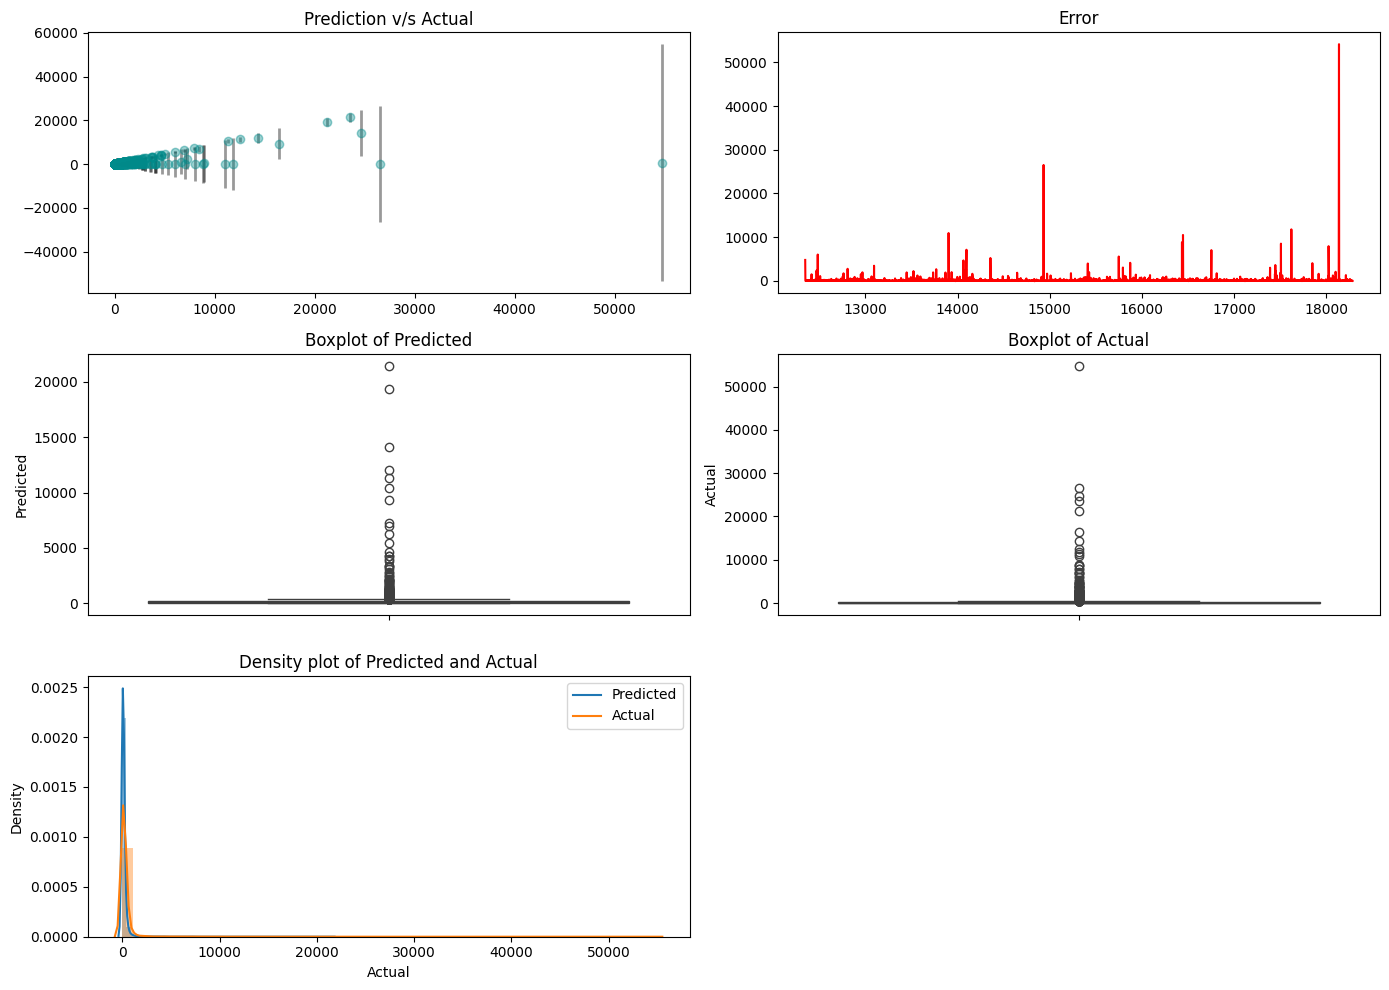

In [46]:
plt.figure(figsize=(14, 10))

# Biểu đồ Prediction v/s Actual
plt.subplot(321)
plt.errorbar(result_p["Actual"], result_p["Predicted"], yerr=np.abs(result_p["Error"]), fmt='o', color='darkcyan',
             ecolor='black', elinewidth=2, capsize=0, alpha=0.4)
plt.title("Prediction v/s Actual")

# Biểu đồ Error
plt.subplot(322)
plt.plot(result_p["Error"], color='r')
plt.title("Error")

# Biểu đồ Boxplot của Predicted và Actual
plt.subplot(323)
sns.boxplot(result_p["Predicted"])
plt.title("Boxplot of Predicted")

plt.subplot(324)
sns.boxplot(result_p["Actual"])
plt.title("Boxplot of Actual")

# Biểu đồ Density plot của Predicted và Actual
plt.subplot(325)
sns.distplot(result_p["Predicted"])
sns.distplot(result_p["Actual"])
plt.legend(["Predicted", "Actual"])
plt.title("Density plot of Predicted and Actual")

plt.tight_layout()
plt.show()

In [47]:
returning_customers_summary["predicted_clv_p"] = ggf.customer_lifetime_value(bgf,
                                                       returning_customers_summary["frequency"],
                                                       returning_customers_summary["recency"],
                                                       returning_customers_summary["T"],
                                                       returning_customers_summary["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [48]:
returning_customers_summary["CLV_p"] = returning_customers_summary["predicted_clv_p"]*0.05 # margin

In [49]:
returning_customers_summary.head(10)

,frequency,recency,T,monetary_value,predicted_purchases,expected_avg_sales_p,actual_30_p,predicted_clv_p,CLV_p
Customer ID,,,,,,,,,
12346.0,2.0,322.0,647.0,38662.955000,0.096628,24944.247004,0.186335,59830.844796,2991.542240
12347.0,7.0,402.0,404.0,615.714286,0.483704,585.645746,0.522388,6896.718957,344.835948
12348.0,4.0,363.0,438.0,359.310000,0.266830,367.615990,0.330579,2399.624122,119.981206
12349.0,2.0,571.0,589.0,1305.085000,0.118312,979.646854,0.105079,2869.465625,143.473281
12352.0,8.0,356.0,392.0,198.223750,0.555462,222.633587,0.674157,3006.256452,150.312823
12353.0,1.0,204.0,408.0,89.000000,0.094813,251.742300,0.147059,585.962000,29.298100
12355.0,1.0,353.0,567.0,459.400000,0.072655,426.644537,0.084986,768.453342,38.422667
12356.0,5.0,402.0,424.0,962.658000,0.340040,859.370605,0.373134,7134.691844,356.734592
12357.0,1.0,355.0,388.0,6207.670000,0.105113,3140.967654,0.084507,8092.320948,404.616047


# Predict in 1 month with duration_holdout = 200

In [ ]:
tm = 30
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(tm, modeldata['frequency'], modeldata['recency'], modeldata['T'])

In [ ]:

summary_cal_holdout = calibration_and_holdout_data(df, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2011-05-23',
                                        observation_period_end='2011-12-09' )

In [ ]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,2.0,322.0,447.0,0.0,200.0
12347.0,3.0,158.0,204.0,4.0,200.0
12348.0,3.0,190.0,238.0,1.0,200.0
12349.0,1.0,182.0,389.0,1.0,200.0
12350.0,0.0,0.0,110.0,0.0,200.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

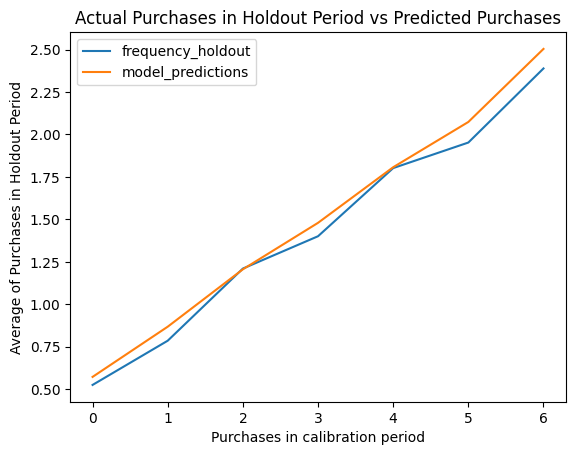

In [ ]:
bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

In [ ]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
Customer ID,,,,,,
12346.0,2.0,322.0,447.0,0.0,200.0,0.483992
12347.0,3.0,158.0,204.0,4.0,200.0,1.268122
12348.0,3.0,190.0,238.0,1.0,200.0,1.132017
12349.0,1.0,182.0,389.0,1.0,200.0,0.327014
12350.0,0.0,0.0,110.0,0.0,200.0,0.382405
...,...,...,...,...,...,...
18283.0,8.0,426.0,458.0,10.0,200.0,1.598215
18284.0,0.0,0.0,231.0,0.0,200.0,0.228874
18285.0,0.0,0.0,460.0,0.0,200.0,0.130089


In [ ]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  2.685799292577637
SMAPE 1.3934845439356414
R2:  0.42588508670330183
